# Classification of Chest and Abdominal X-rays
## Classificação de radiografias de peito e abdominais
Este é um exemplo de modelo que ao receber um exame de imagem, classifica-o como radiografia do peito ou abdominal.

Code Source: Lakhani, P., Gray, D.L., Pett, C.R. et al. J Digit Imaging (2018) 31: 283. https://doi.org/10.1007/s10278-018-0079-6

The code to download and prepare dataset had been modified form the original source code.

In [1]:
# Carrega as bibliotecas necessárias para treinamento do modelo (utilizaremos o Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
!rm -rf /content/*

In [3]:
# Faz o Download do dataset
!wget https://github.com/kunkaweb/Hello_World_Deep_Learning/blob/master/Open_I_abd_vs_CXRs.zip?raw=true

--2021-09-22 22:08:04--  https://github.com/kunkaweb/Hello_World_Deep_Learning/blob/master/Open_I_abd_vs_CXRs.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kunkaweb/Hello_World_Deep_Learning/raw/master/Open_I_abd_vs_CXRs.zip [following]
--2021-09-22 22:08:04--  https://github.com/kunkaweb/Hello_World_Deep_Learning/raw/master/Open_I_abd_vs_CXRs.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kunkaweb/Hello_World_Deep_Learning/master/Open_I_abd_vs_CXRs.zip [following]
--2021-09-22 22:08:04--  https://raw.githubusercontent.com/kunkaweb/Hello_World_Deep_Learning/master/Open_I_abd_vs_CXRs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.gi

In [4]:
# Renomeia arquivo
!mv Open_I_abd_vs_CXRs.zip?raw=true Open_I_abd_vs_CXRs.zip

In [5]:
# Mostra arquivos na pasta
!ls /content

Open_I_abd_vs_CXRs.zip


In [6]:
# Descompacta arquivo
!unzip /content/Open_I_abd_vs_CXRs.zip

Archive:  /content/Open_I_abd_vs_CXRs.zip
   creating: Open_I_abd_vs_CXRs/
   creating: Open_I_abd_vs_CXRs/TEST/
  inflating: Open_I_abd_vs_CXRs/TEST/abd2.png  
  inflating: Open_I_abd_vs_CXRs/TEST/chest2.png  
   creating: Open_I_abd_vs_CXRs/VAL/
   creating: Open_I_abd_vs_CXRs/TRAIN/
   creating: Open_I_abd_vs_CXRs/VAL/openI_abd_xray/
  inflating: Open_I_abd_vs_CXRs/VAL/openI_abd_xray/PMC2584007_1752-1947-2-335-2.png  
  inflating: Open_I_abd_vs_CXRs/VAL/openI_abd_xray/PMC2584007_1752-1947-2-335-2 (1).png  
  inflating: Open_I_abd_vs_CXRs/VAL/openI_abd_xray/openI_22.png  
  inflating: Open_I_abd_vs_CXRs/VAL/openI_abd_xray/openI_21.png  
  inflating: Open_I_abd_vs_CXRs/VAL/openI_abd_xray/openI_20.png  
   creating: Open_I_abd_vs_CXRs/VAL/openI_CXR/
  inflating: Open_I_abd_vs_CXRs/VAL/openI_CXR/20_IM-0653-1001.png  
  inflating: Open_I_abd_vs_CXRs/VAL/openI_CXR/17_IM-0460-2001_invert.png  
  inflating: Open_I_abd_vs_CXRs/VAL/openI_CXR/12_IM-0133-1001_invert.png  
  inflating: Open_I_ab

In [7]:
# Define as dimensões das imagens
img_width, img_height = 299, 299

# Diretórios de TREINAMENTO e VALIDAÇÃO das imagens
train_data_dir = 'Open_I_abd_vs_CXRs/TRAIN/'
validation_data_dir = 'Open_I_abd_vs_CXRs/VAL/'

# epochs = Numéro de épocas - vezes que passaremos sobre os dados de treinamento
# batch_size = Número de imagen processadas simultaneamente
train_samples = 65
validation_samples = 10
epochs = 20
batch_size = 5

In [8]:
# Define uma rede do tipo Inception V3 e use utiliza pesos de uma modelo pré-treinado no ImageNet (Transfer Learning)
# Remove o topo da rede, pois iremos acoplar uma sequência de rede que ira performar a classificação posteriormente (include_top = False)
base_model = applications.InceptionV3(weights='imagenet', include_top=False,
                                     input_shape=(img_width, img_height,3))

87924736/87910968 [==============================] - 2s 0us/step


In [9]:
# Constroi um modelo de classificação para colocar no topo da rede convolucional
# Consiste em um global average pooling layer e um fully connected layer com 256 nós
# Então aplica-se o dropout e uma função de ativação do tipo sigmóide

model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:],
                                    data_format=None)),
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

# Compila o modelo utilizando o otimizador Adam 
# Utiliza uma taxa de aprendizado baixa (low learning rate - lr) para o transfer learning
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [10]:
# Configurações extras
train_datagen = ImageDataGenerator(
  rescale = 1./255, # Rescale pixel values to 0-1 to aid CNN processing
  shear_range = 0.2, # 0-1 range for shearing
  zoom_range = 0.2, # 0-1 range for zoom
  rotation_range = 20, # 0.180 range, degrees of rotation
  width_shift_range = 0.2, # 0-1 range horizontal translation
  height_shift_range = 0.2, # 0-1 range vertical translation
  horizontal_flip = True # set True or false
)

val_datagen = ImageDataGenerator(
  rescale=1./255 # Rescale pixel values to 0-1 to aid CNN processing
)

In [11]:
# Class mode é definida como 'binary' pois temos um problema com duas classes (chest e abdominal)
# O gerador embaralha as imagens e envia elas em lotes para a rede - cada classe tem seu diretório próprio
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [12]:
# Ajusta (fine-tune) o modelo Inception V3 pré-treinado utilizando o data generator
# Especifica as etapas por época (número de imagens/batch_size)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples//batch_size
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
13/13 [==============================] - 57s 404ms/step - loss: 0.5262 - accuracy: 0.7231 - val_loss: 0.6036 - val_accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 4s 274ms/step - loss: 0.2641 - accuracy: 0.9231 - val_loss: 0.1384 - val_accuracy: 1.0000
Epoch 3/20
13/13 [==============================] - 4s 274ms/step - loss: 0.0584 - accuracy: 0.9846 - val_loss: 0.1513 - val_accuracy: 1.0000
Epoch 4/20
13/13 [==============================] - 4s 274ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.1088 - val_accuracy: 1.0000
Epoch 5/20
13/13 [==============================] - 4s 273ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 6/20
13/13 [==============================] - 4s 274ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 7/20
13/13 [==============================] - 4s 331ms/step - loss: 0.0958 - accuracy: 0.9538 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


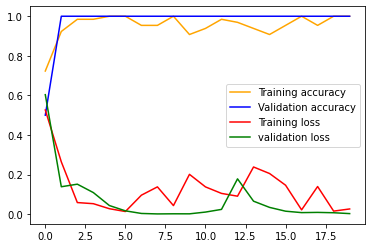

In [13]:
# Plota a curva de aprendizagem
import matplotlib.pyplot as plt
print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'],'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'],'blue', label='Validation accuracy')
plt.plot(history.history['loss'],'red', label='Training loss')
plt.plot(history.history['val_loss'],'green', label='validation loss')
plt.legend()
plt.show()

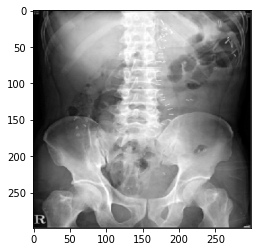

Predito: [[0.999243]] Radiografia abdominal


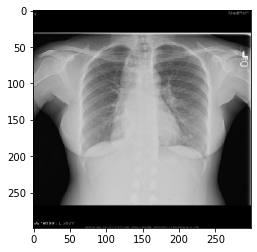

Predito: [[8.452372e-06]] Radiografia do peito


In [15]:
import numpy as np
from keras.preprocessing import image

# Carrega, redimensiona, e mostra duas imagens no lote de TESTE
img_path = 'Open_I_abd_vs_CXRs/TEST/abd2.png'
img_path2 = 'Open_I_abd_vs_CXRs/TEST/chest2.png'
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()

# Converte a imagem em um vetor, assim o Keras consegue renderizar a predição
img = image.img_to_array(img)

# Expande o vetor de 3 dimensões (altura, largura, canais) para 4 dimensões (batch size, altura, largura, canais)
# Redimensiona os valores dos pixels para 0-1
x = np.expand_dims(img, axis=0) * 1./255

# Faz predição da imagem de teste 1
# Caso score seja menor que 0.5 = peito, senão = abdominal
score = model.predict(x)
print('Predito:', score, 'Radiografia do peito' if score < 0.5 else 'Radiografia abdominal')

# Mostra e rendereiza a predição da segunda imagem
plt.imshow(img2)
plt.show()
img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score = model.predict(x)
print('Predito:', score, 'Radiografia do peito' if score < 0.5 else 'Radiografia abdominal')
